In [1]:
!ls

drive  logs.log  sample_data


In [2]:
%cd drive/MyDrive/Hackathon/HackUTD/

/content/drive/MyDrive/Hackathon/HackUTD


In [4]:
!pip install pycaret pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.7 MB/s eta 0:00:00
   ━━━━

In [3]:
import pandas as pd
import numpy as np
from pycaret.classification import *
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def preprocess_data(df):
    """Preprocess the data and engineer features."""
    # Convert time to datetime
    df['Time'] = pd.to_datetime(df['Time'])

    # Fill missing values
    df = df.fillna(method='ffill')

    # Create features
    df['hour'] = df['Time'].dt.hour
    df['valve_change'] = df['Inj Gas Valve Percent Open'].diff()
    df['volume_diff'] = df['Inj Gas Meter Volume Instantaneous'] - df['Inj Gas Meter Volume Setpoint']
    df['volume_change'] = df['Inj Gas Meter Volume Instantaneous'].diff()

    # Calculate rolling statistics
    df['volume_rolling_mean'] = df['Inj Gas Meter Volume Instantaneous'].rolling(window=6).mean()
    df['volume_rolling_std'] = df['Inj Gas Meter Volume Instantaneous'].rolling(window=6).std()

    # Create hydrate formation label
    df['hydrate_forming'] = ((df['volume_change'] < -20) &
                           (df['Inj Gas Valve Percent Open'].diff() > 5)).astype(int)

    # Create lag features
    for i in [1, 2, 3]:
        df[f'volume_lag_{i}'] = df['Inj Gas Meter Volume Instantaneous'].shift(i)
        df[f'valve_lag_{i}'] = df['Inj Gas Valve Percent Open'].shift(i)

    # Drop rows with NaN values
    df = df.dropna()

    return df

In [5]:
def load_all_data(file_paths):
    all_data = []
    for file in file_paths:
        df = pd.read_csv(file)
        processed_df = preprocess_data(df)
        all_data.append(processed_df)
    return pd.concat(all_data, ignore_index=True)

In [6]:
file_paths = [
  './data/Bold_744H-10_31-11_07.csv',
  './data/Courageous_729H-09_25-09_28.csv',
  './data/Fearless_709H-10_31-11_07.csv',
  './data/Gallant_102H-10_04-10_11.csv',
  './data/Noble_4H-10_24-10_29.csv',
  './data/Resolute_728H-10_14-10_21.csv',
  './data/Ruthless_745H-10_01-10_08.csv'
]

In [7]:
# Load and process all data
data = load_all_data(file_paths)

In [8]:
# Select features for modeling
features = [
    'hour', 'Inj Gas Valve Percent Open', 'volume_diff',
    'volume_rolling_mean', 'volume_rolling_std', 'valve_change',
    'volume_lag_1', 'volume_lag_2', 'volume_lag_3',
    'valve_lag_1', 'valve_lag_2', 'valve_lag_3'
]

In [9]:
# Prepare the final dataset for AutoML
automl_data = data[features + ['hydrate_forming']].copy()

In [17]:
!pip install mlflow

In [23]:
pip install --upgrade pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 72.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flask to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━

In [10]:
import mlflow
# Initialize PyCaret setup with class imbalance handling
clf = setup(data=automl_data,
           target='hydrate_forming',
           session_id=42,
           fix_imbalance=True,  # Handle class imbalance
           normalize=True,      # Normalize features
           remove_multicollinearity=True,
           multicollinearity_threshold=0.9,
           log_experiment=True,
           experiment_name='hydrate_detection')

,Description,Value
0,Session id,42
1,Target,hydrate_forming
2,Target type,Binary
3,Original data shape,"(19123, 13)"
4,Transformed data shape,"(32465, 7)"
5,Transformed train set shape,"(26728, 7)"
6,Transformed test set shape,"(5737, 7)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


2024/11/17 00:52:39 INFO mlflow.tracking.fluent: Experiment with name 'hydrate_detection' does not exist. Creating a new experiment.


In [11]:
best_model = compare_models(sort='f1', n_select=1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9982,0.9982,0.7500,0.5556,0.6064,0.6056,0.6270,0.2050
catboost,CatBoost Classifier,0.9980,0.9993,0.8333,0.4833,0.5921,0.5913,0.6225,7.8040
rf,Random Forest Classifier,0.9982,0.9993,0.7167,0.5702,0.5844,0.5837,0.6114,2.2010
lightgbm,Light Gradient Boosting Machine,0.9981,0.9239,0.6667,0.5119,0.5544,0.5536,0.5700,0.9000
et,Extra Trees Classifier,0.9983,0.9990,0.6667,0.5167,0.5533,0.5525,0.5709,0.6030
gbc,Gradient Boosting Classifier,0.9976,0.9984,0.7667,0.4043,0.5244,0.5233,0.5527,4.4760
dt,Decision Tree Classifier,0.9981,0.7994,0.6000,0.5033,0.5224,0.5215,0.5357,0.2550
ada,Ada Boost Classifier,0.9974,0.9914,0.6500,0.3689,0.4554,0.4543,0.4793,1.3040
svm,SVM - Linear Kernel,0.9933,0.9991,1.0000,0.2121,0.3465,0.3447,0.4547,0.1390
knn,K Neighbors Classifier,0.9954,0.8318,0.6667,0.2191,0.3166,0.3149,0.3711,0.1880


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

2024/11/17 00:56:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 00:56:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 00:56:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 00:57:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 00:57:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 00:57:02 

In [12]:
tuned_model = tune_model(best_model, optimize='f1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9970,0.9839,0.5000,0.2500,0.3333,0.3320,0.3522
1,0.9970,0.9978,0.5000,0.2500,0.3333,0.3320,0.3522
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9978,0.9993,0.5000,0.3333,0.4000,0.3989,0.4072
4,0.9970,0.9985,0.3333,0.3333,0.3333,0.3318,0.3318
5,0.9993,0.9995,1.0000,0.7500,0.8571,0.8568,0.8657
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9948,1.0000,1.0000,0.2222,0.3636,0.3621,0.4702
8,0.9985,0.9989,1.0000,0.5000,0.6667,0.6660,0.7066


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


2024/11/17 00:58:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


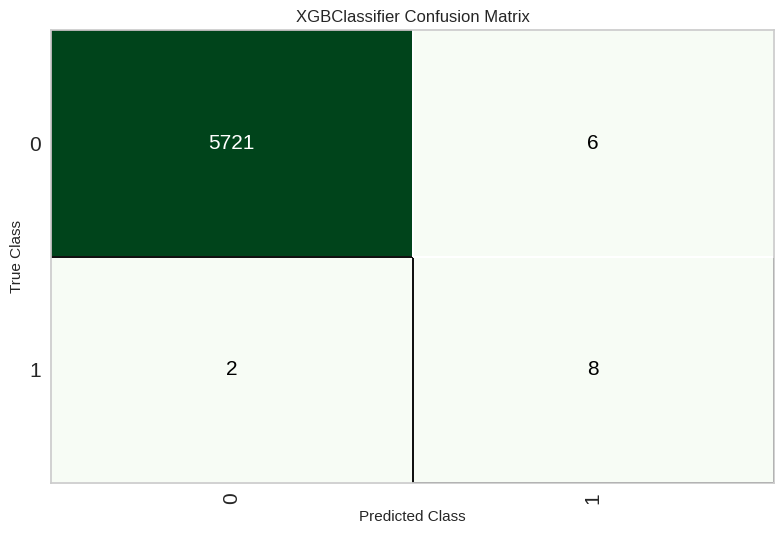

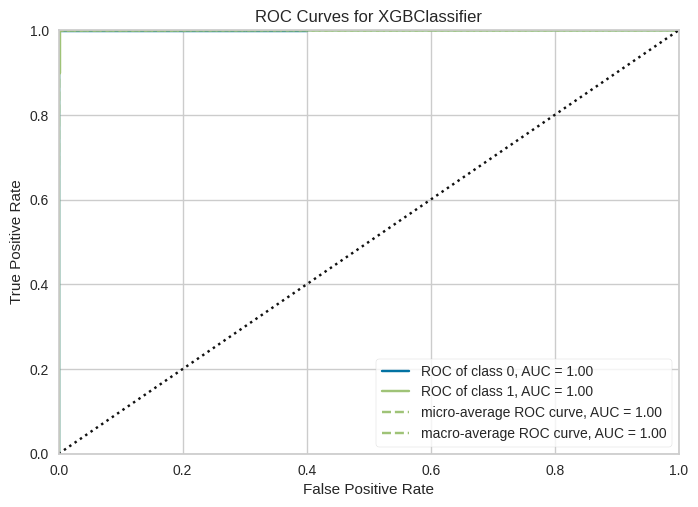

ValueError: Plot Not Available. Please see docstring for list of available Plots.

In [13]:
plot_model(tuned_model, plot='confusion_matrix')
plot_model(tuned_model, plot='auc')
plot_model(tuned_model, plot='feature_importance')
plot_model(tuned_model, plot='precision_recall')

In [14]:
final_model = finalize_model(tuned_model)

2024/11/17 00:58:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [15]:
save_model(final_model, 'hydrate_detection_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['hour',
                                              'Inj Gas Valve Percent Open',
                                              'volume_diff',
                                              'volume_rolling_mean',
                                              'volume_rolling_std',
                                              'valve_change', 'volume_lag_1',
                                              'volume_lag_2', 'volume_lag_3',
                                              'valve_lag_1', 'valve_lag_2',
                                              'valve_lag_3'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=...
                                importance_type=None,
                                intera

In [18]:
def predict_hydrate_risk(new_data):
    """
    Predict hydrate formation risk for new data.

    Args:
        new_data (pd.DataFrame): New data with required columns

    Returns:
        predictions, prediction_probabilities
    """
    # Preprocess new data
    processed_data = preprocess_data(new_data)

    # Select features
    prediction_data = processed_data[features]

    # Make predictions
    predictions = predict_model(final_model, data=prediction_data)

    return predictions

In [19]:
def test_model(test_file):
    """Test the model with new data."""
    # Load test data
    test_data = pd.read_csv(test_file)

    # Make predictions
    predictions = predict_hydrate_risk(test_data)

    # Print results
    print("\nPrediction Results:")
    print("===================")
    print(f"Total Samples: {len(predictions)}")
    print(f"Predicted Hydrate Formations: {predictions['prediction_label'].sum()}")

    # Plot prediction probabilities
    plt.figure(figsize=(10, 6))
    plt.hist(predictions['prediction_score'], bins=50)
    plt.title('Distribution of Hydrate Formation Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

    return predictions

In [17]:
def monitor_real_time(data_stream, risk_threshold=0.7):
    """
    Monitor real-time data for hydrate formation risk.

    Args:
        data_stream: Iterator or generator of new data
        risk_threshold: Threshold for triggering alerts
    """
    for chunk in data_stream:
        # Make predictions
        predictions = predict_hydrate_risk(chunk)

        # Check for high-risk situations
        high_risk = predictions[predictions['prediction_score'] > risk_threshold]

        if len(high_risk) > 0:
            print("\nHIGH RISK ALERT!")
            print("================")
            print(f"Number of high-risk points detected: {len(high_risk)}")
            print(f"Maximum risk score: {high_risk['prediction_score'].max():.2%}")

        # Return predictions for further processing if needed
        yield predictions


Prediction Results:
Total Samples: 1719
Predicted Hydrate Formations: 5


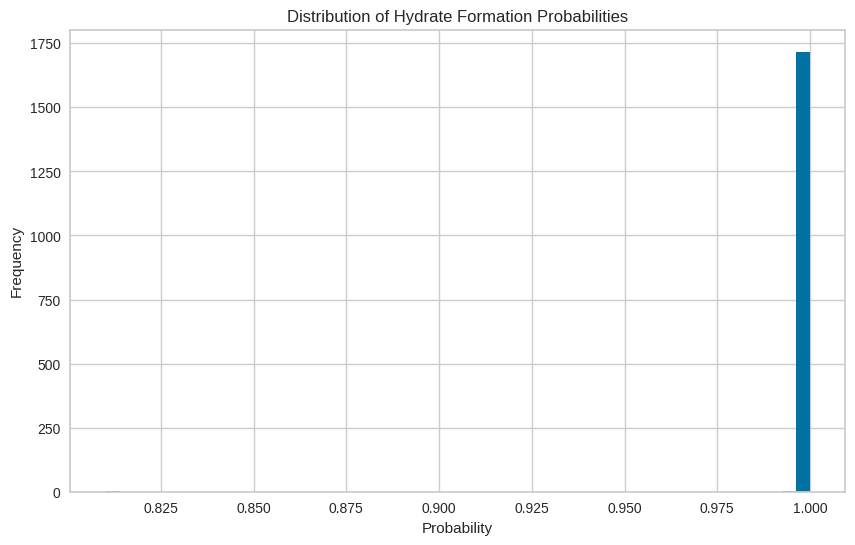

,hour,Inj Gas Valve Percent Open,volume_diff,volume_rolling_mean,volume_rolling_std,valve_change,volume_lag_1,volume_lag_2,volume_lag_3,valve_lag_1,valve_lag_2,valve_lag_3,prediction_label,prediction_score
7,2,43.519451,32.668427,935.163757,7.760625,0.0,939.309875,939.192139,934.175110,43.519451,43.519451,43.519451,0,1.0
8,2,43.519451,31.506300,938.671143,3.806759,0.0,943.168396,939.309875,939.192139,43.519451,43.519451,43.519451,0,1.0
9,2,43.519451,31.827600,940.029907,3.302570,0.0,942.006287,943.168396,939.309875,43.519451,43.519451,43.519451,0,1.0
10,2,43.519451,38.151150,942.442566,3.454149,0.0,942.327576,942.006287,943.168396,43.519451,43.519451,43.519451,0,1.0
11,2,43.519451,43.231049,944.865723,5.315823,0.0,948.651123,942.327576,942.006287,43.519451,43.519451,43.519451,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721,23,34.468460,-20.967751,849.794983,4.203581,0.0,854.316528,851.088501,850.287720,34.468460,34.468460,34.468460,0,1.0
1722,23,34.468460,-21.892574,851.248474,3.119986,0.0,853.532227,854.316528,851.088501,34.468460,34.468460,34.468460,0,1.0
1723,23,34.468460,-20.891138,852.573547,1.578629,0.0,852.607422,853.532227,854.316528,34.468460,34.468460,34.468460,0,1.0
1724,23,34.468460,-23.175375,852.746399,1.312713,0.0,853.608887,852.607422,853.532227,34.468460,34.468460,34.468460,0,1.0


In [20]:
test_model("./data/Valiant_505H-09_22-09_30.csv")